In [1]:
from prysm.coordinates import make_xy_grid, cart_to_polar
from prysm.propagation import (
    focus_fixed_sampling,
    angular_spectrum
)
from prysm.propagation import (Wavefront as WF,
                               angular_spectrum_transfer_function,
                               Q_for_sampling)

from prysm.geometry import circle,spider
from prysm.polynomials import (
    noll_to_nm,
    zernike_nm,
    zernike_nm_seq,
    hopkins,
    sum_of_2d_modes
)

from prysm.fttools import (fourier_resample,
                           crop_center,
                           pad2d,
)

from prysm import mathops, conf
mathops.set_backend_to_cupy()
# conf.config.precision = 32
from astropy.io import fits

from prysm.mathops import (np,
                           fft,
                           interpolate,
                           ndimage)

import matplotlib.pyplot as plt

import sys
from lina.phase_retrieval import ADPhaseRetireval, ParallelADPhaseRetrieval

from psd_utils import PSDUtils

from scipy.optimize import minimize
from scipy.interpolate import RegularGridInterpolator

In [2]:
class telescope:

    def __init__(self, 
                 npix,
                 roi,
                 wvls, 
                 wvl_weights, 
                 src_magnitudes, 
                 src_positions,
                 axial_shifts,):

        ##### MODEL PARAMETERS #####

        # user-defined
        self.npix = npix                # pix
        self.roi = roi                # pix
        self.wvls = wvls                            # um
        self.wvl_weights = wvl_weights              # must sum to 1
        self.src_magnitudes = src_magnitudes        # Rmag
        self.src_positions = src_positions          # arcsec
        self.axial_shifts = axial_shifts            # mm

        # stuff that will be imported from toml/yaml
        D_obs = 1300                           # M2 obsurcation diameter [mm]
        D_spider = 150                         # spider diameter [mm]

        self.f_m1 = 8.127911063351532e3
        self.f_m2 = -8.304252504657864e2
        self.f_m3 = 9.263970967059440e2
        self.f_m4 = np.inf                          # M4 focal length [mm]
        
        BD_m1 = 3.210000000000000e3 * 2                     # beam diameter on M1 [mm]
        self.dx_m1 = BD_m1 / npix         # beam pixelscale on M1 [mm/pix]
        BD_m2 = 2.892063493800492e2 * 2            # beam diameter on M2 [mm]
        self.dx_m2 = BD_m2 / npix         # beam pixelscale on M2 [mm/pix]
        BD_m3 = 4.159732311628925e1 * 2            # beam diameter on M3 [mm]
        self.dx_m3 = BD_m3 / npix         # beam pixelscale on M3 [mm/pix]
        BD_m4 = 85.61819                       # beam diameter on M4 [mm]
        self.dx_m4 = BD_m4 / npix         # beam pixelscale on M4 [mm/pix]

        self.d_m1_to_m2 = 7.400157661890971e3
        self.d_m2_to_m3 = 7.437545621116708e3
        self.d_m3_to_m4 = 1.044644086769678e3
        self.d_m4_to_det = 1.254956768383789e3

        ##### CONSTRUCT MODEL #####

        # M1 grids
        x_m1, y_m1 = make_xy_grid(npix, dx=self.dx_m1)
        r_m1, t_m1 = cart_to_polar(x_m1, y_m1)

        # M2 grids
        x_m2, y_m2 = make_xy_grid(npix, dx=self.dx_m2)
        r_m2, t_m2 = cart_to_polar(x_m2, y_m2)

        # M3 grids
        x_m3, y_m3 = make_xy_grid(npix, dx=self.dx_m3)
        r_m3, t_m3 = cart_to_polar(x_m3, y_m3)

        # M4 grids
        x_m4, y_m4 = make_xy_grid(npix, dx=self.dx_m4)
        r_m4, t_m4 = cart_to_polar(x_m4, y_m4)

        # aperture
        s1 = spider(1, D_spider, x_m1, y_m1, rotation=0)
        s2 = spider(1, D_spider, x_m1, y_m1, rotation=120)
        s3 = spider(1, D_spider, x_m1, y_m1, rotation=240)
        spiders = s1 & s2 & s3
        self.aperture = (circle(BD_m1 / 2, r_m1) ^ circle(D_obs / 2, r_m1)) & spiders

        # M1 optic
        self.m1_quadratic_phase = self._thin_lens(self.f_m1, x_m1, y_m1)

        # M2 optic
        self.m2_quadratic_phase = self._thin_lens(self.f_m2, x_m2, y_m2)

        # M3 optic
        self.m3_quadratic_phase = self._thin_lens(self.f_m3, x_m3, y_m3)

        # M4 optic
        self.m4_quadratic_phase = self._thin_lens(self.f_m4, x_m3, y_m3)


    def _thin_lens(self, f, x, y,):

        rsq = x * x + y * y

        quadratic_phase = rsq / (2 * f)

        return quadratic_phase

    def create_wavefront(self, wvl, src_magnitude, src_position,):

        wavefront = WF.from_amp_and_phase(self.aperture, None, wvl, self.dx_m1)

        return wavefront
    
    def get_field_aberration(src_position,):

        return None


    def _fwd(self, wvl, src_magnitude, src_position, shift, debug=False):

        before_m1 = self.create_wavefront(wvl, src_magnitude, src_position)

        after_m1 = before_m1 * WF.phase_screen(self.m1_quadratic_phase, wvl, self.dx_m1)

        # before_m2 = angular_spectrum(after_m1.data, wvl, self.dx_m1, self.d_m1_to_m2)
        before_m2 = after_m1.free_space(dz=self.d_m1_to_m2, Q=2)

        after_m2 = before_m2 * WF.phase_screen(self.m2_quadratic_phase, wvl, self.dx_m2)

        # before_m3 = angular_spectrum(after_m2.data, wvl, self.dx_m2, self.d_m2_to_m3)
        before_m3 = after_m2.free_space(dz=self.d_m2_to_m3, Q=2)

        after_m3 = before_m3 * WF.phase_screen(self.m3_quadratic_phase, wvl, self.dx_m3)

        # before_m4 = angular_spectrum(after_m3.data, wvl, self.dx_m3, self.d_m3_to_m4)
        before_m4 = after_m3.free_space(dz=self.d_m3_to_m4, Q=2)

        after_m4 = before_m4 * WF.phase_screen(self.m4_quadratic_phase, wvl, self.dx_m4)

        # at_detector = angular_spectrum(after_m4.data, wvl, self.dx_m4, self.d_m4_to_det + shift)
        at_detector = after_m4.free_space(dz=self.d_m4_to_det + shift, Q=2)

        if debug:
            fields = {'M1' : (before_m1, after_m1),
                      'M2' : (before_m2, after_m2),
                      'M3' : (before_m3, after_m3),
                      'M4' : (before_m4, after_m4),
                      'Detector' : at_detector}
            return fields
        
        else:
            return np.abs(at_detector ** 2)



    def snap(self,):

        images = []
            
        for src_magnitude, src_position, dz in zip(self.src_magnitudes, self.src_positions, self.axial_shifts):

            detector_intensities = []

            for wvl in self.wvls:
                
                detector_intensity = self._fwd(wvl, src_magnitude, src_position, dz)

                detector_intensities.append(detector_intensity)

            psf = sum_of_2d_modes(detector_intensities, self.wvl_weights)

            images.append(psf)

        return images

In [9]:
model = telescope(npix=4096,
                  roi=128,
                  wvls=list(np.linspace(0.575, 0.725, 25).get()),
                  wvl_weights=np.ones((25,)),
                  src_magnitudes=[0],
                  src_positions=[(0, 0)],
                  axial_shifts=[0])

1.5673828125


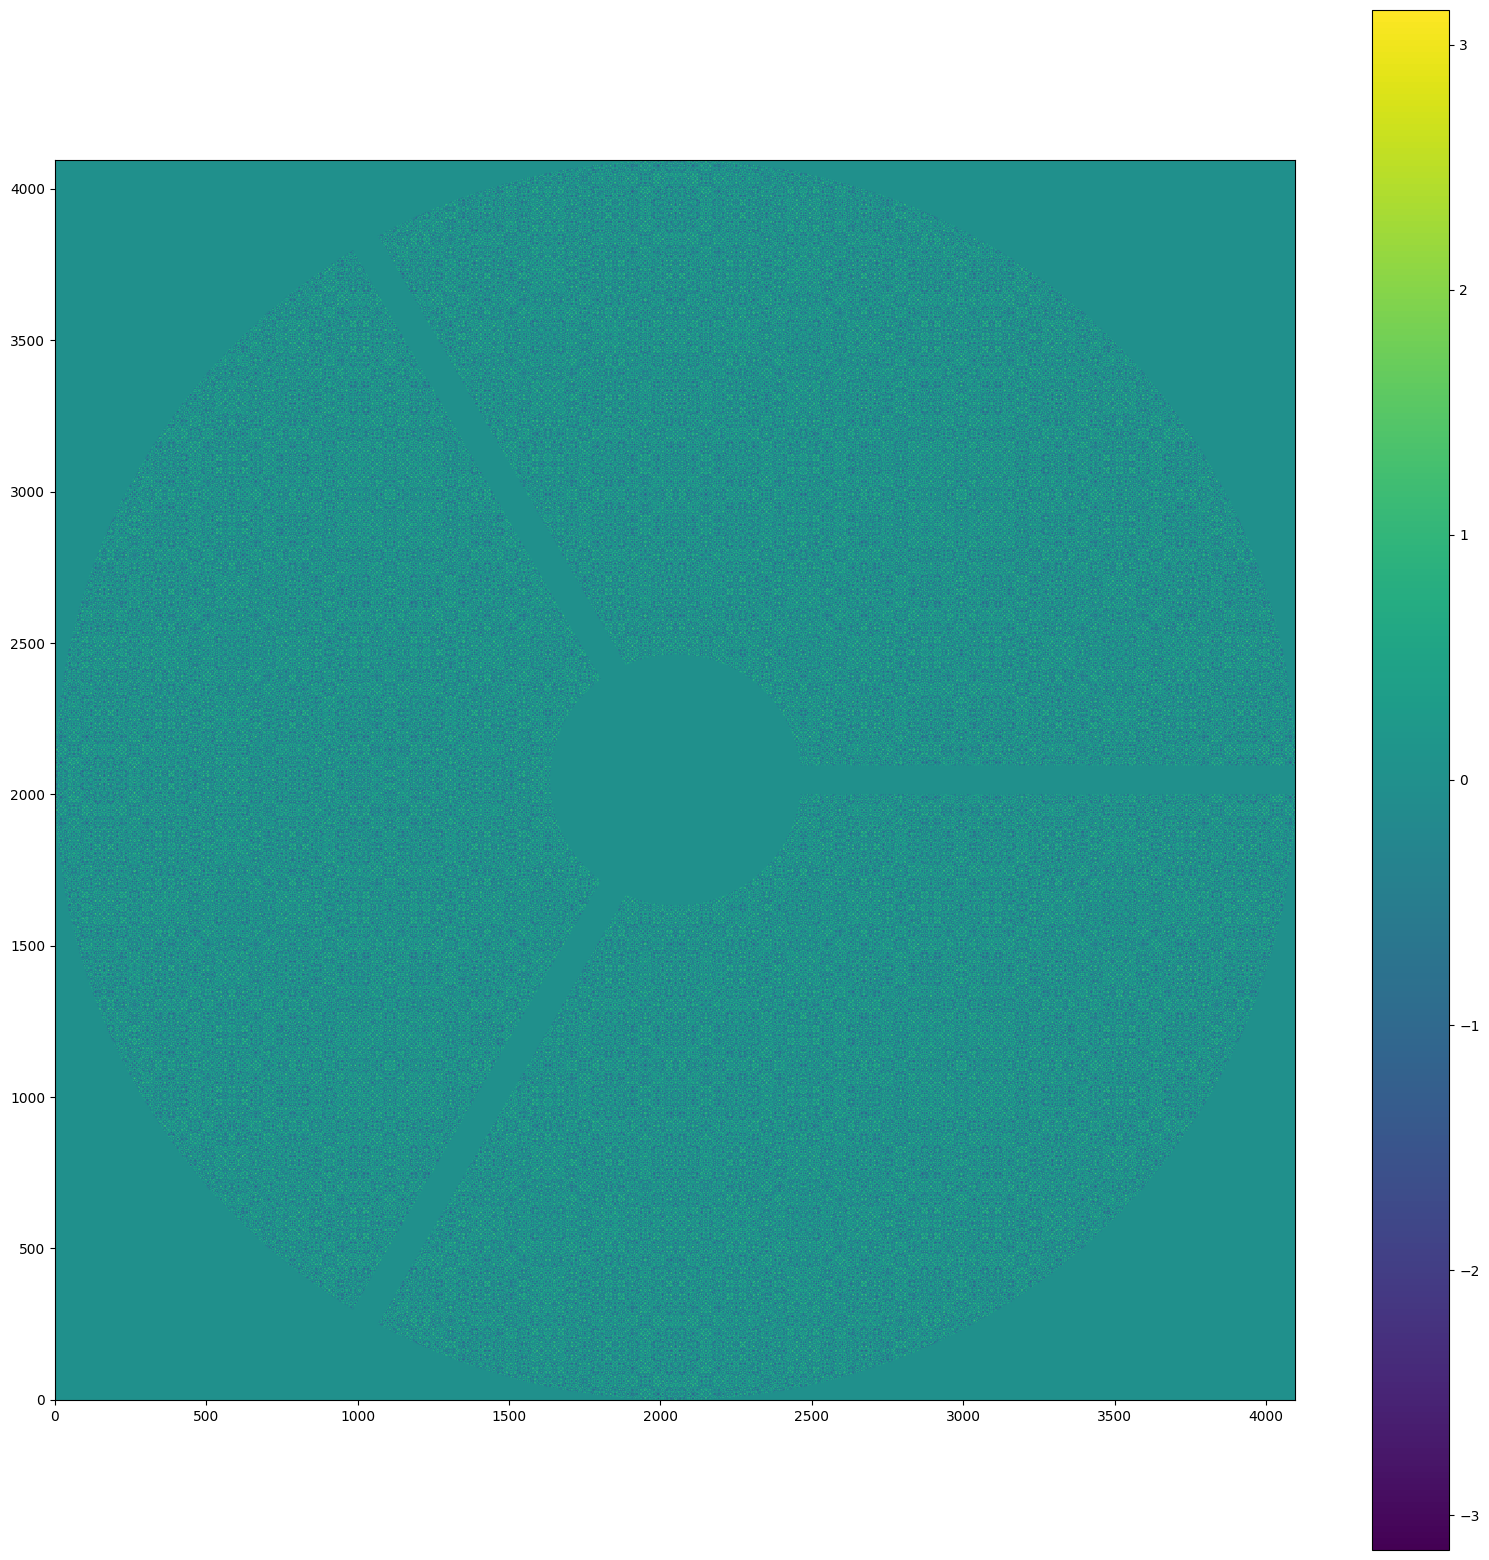

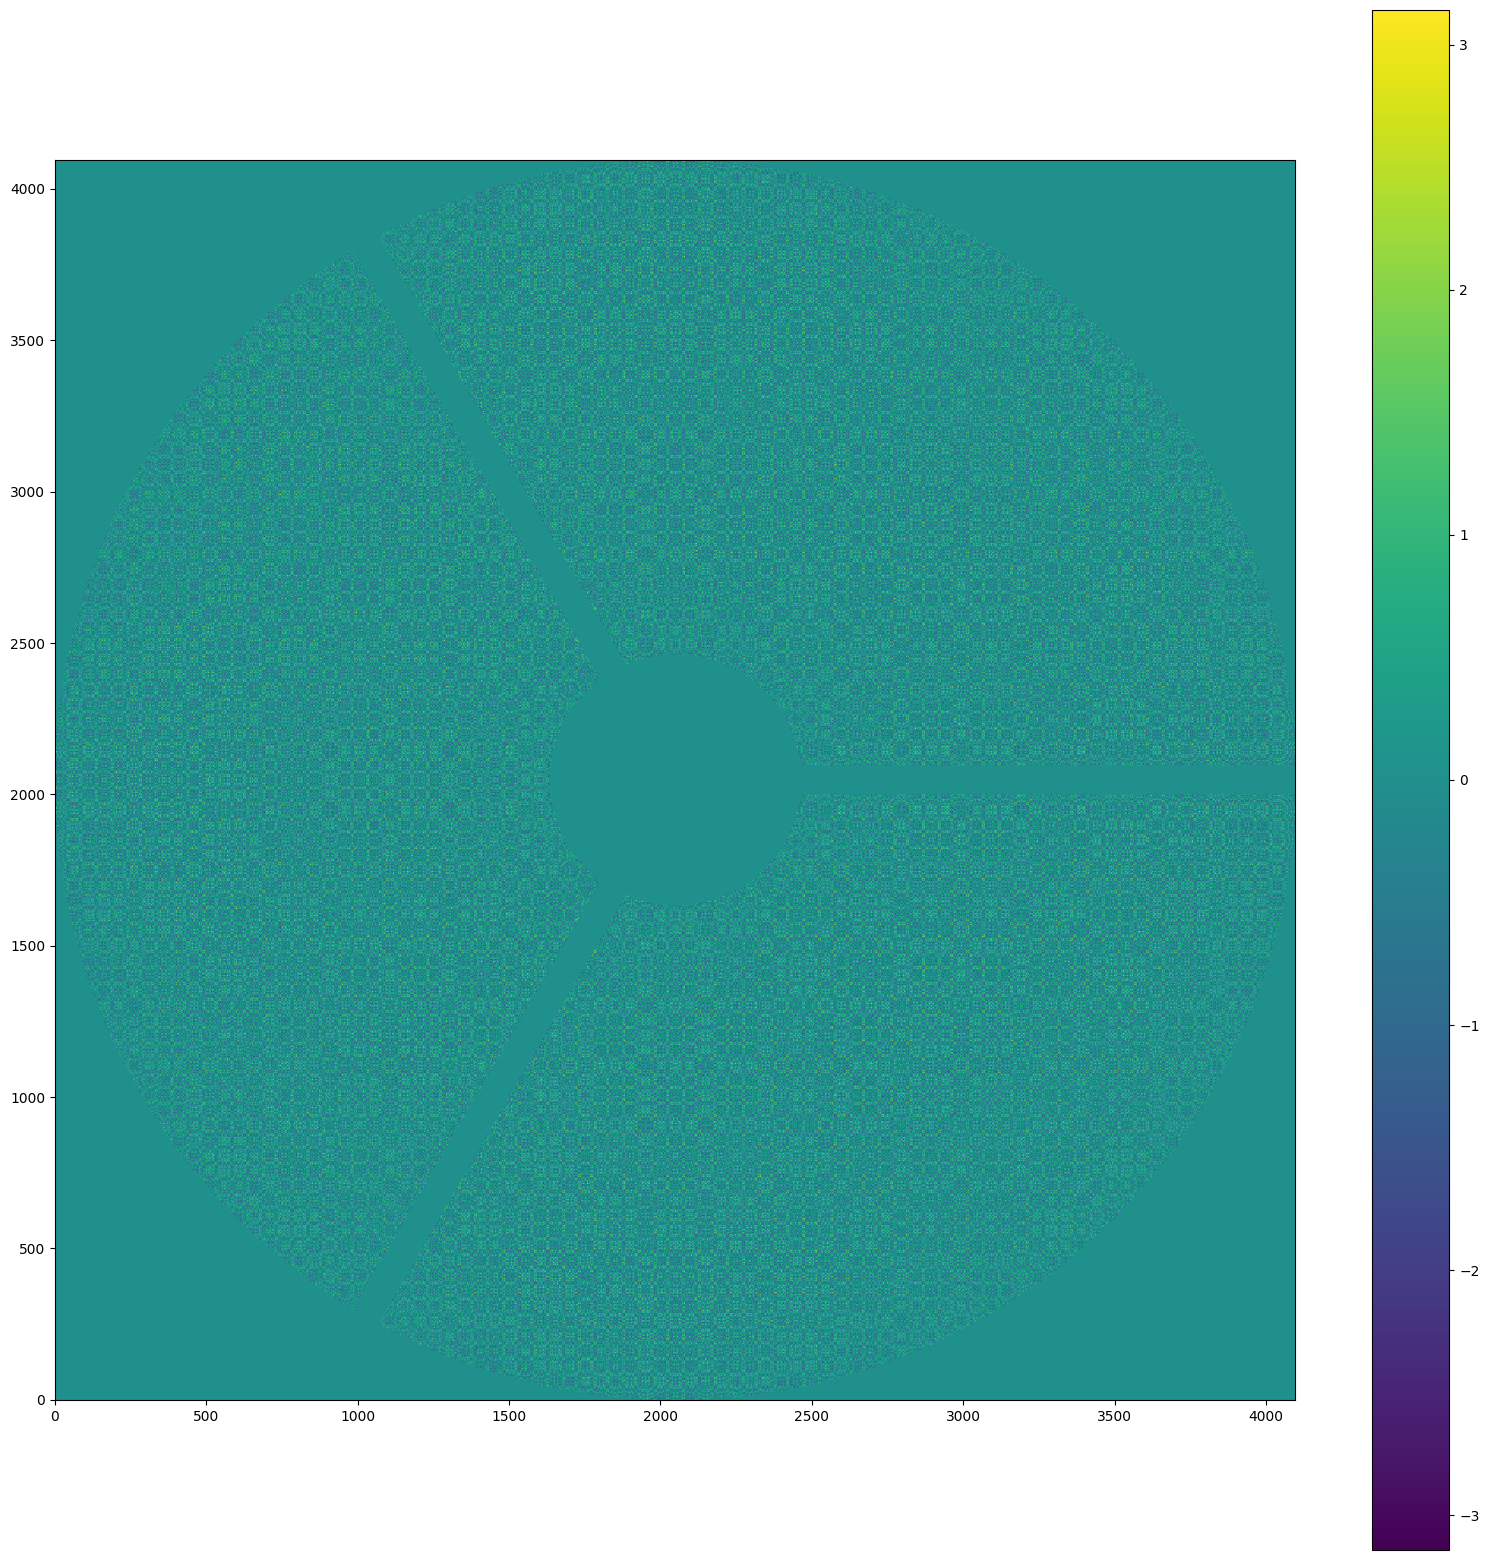

In [14]:
before_m1 = model.create_wavefront(0.65, 0, 0)

x_m1, y_m1 = make_xy_grid(4096, dx=model.dx_m1)

lens = WF.thin_lens(8.127911063351532e3, 0.65, x_m1, y_m1)

after_m1 = before_m1 * lens #WF.phase_screen(model.m1_quadratic_phase * 1e3, 0.65, model.dx_m1)

before_m2 = angular_spectrum(after_m1.data, 0.65, model.dx_m1, model.d_m1_to_m2 * 1e3)
# before_m2 = after_m1.free_space(dz=model.d_m1_to_m2 * 1e3, Q=1)

plt.figure(figsize=(20, 20))
plt.imshow(np.angle(after_m1.data).get() * model.aperture.get())
plt.colorbar()
plt.figure(figsize=(20,20))
plt.imshow(np.angle(before_m2).get()[4096-2048:4096+2048, 4096-2048:4096+2048] * model.aperture.get())
plt.colorbar()
print(model.dx_m1)

# 

In [26]:
dbg = model._fwd(wvl=0.65, src_magnitude=0, src_position=(0, 0), shift=0, debug=True)

ValueError: all physicality criteria not met: sample spacing, shape, or wavelength different.